## Exploring 'Ratings' table
### 1 Library and duckdb file import

In [84]:

# initial exploration of "ratings" table
import duckdb, pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

#create or connect if it already exists
con = duckdb.connect("movielensfull33M.duckdb")

### 2 General dataset description

In [85]:
con.sql("DESCRIBE ratings").df()


,column_name,column_type,null,key,default,extra
0,userId,INTEGER,YES,None,None,None
1,movieId,INTEGER,YES,None,None,None
2,rating,DOUBLE,YES,None,None,None
3,timestamp,TIMESTAMP WITH TIME ZONE,YES,None,None,None


Comment

- `userId`: INTEGER  
- `movieId`: INTEGER  
- `rating`: DOUBLE  
- `timestamp`: TIMESTAMP WITH TIME ZONE

- The `null` column indicates whether the field can contain null (NULL) values.  
  - In this case, it can.

- The `key` column indicates whether the field is a primary key (PRIMARY KEY).  
  - It is not.

- The `default` column shows the default value (DEFAULT).  
  - None.

- The `extra` column displays additional information about the field, such as auto_increment or generated.  
  - None in this case.


In [86]:
#see data types of each column
con.sql("PRAGMA table_info('ratings')").df()

,cid,name,type,notnull,dflt_value,pk
0,0,userId,INTEGER,False,None,False
1,1,movieId,INTEGER,False,None,False
2,2,rating,DOUBLE,False,None,False
3,3,timestamp,TIMESTAMP WITH TIME ZONE,False,None,False


### 3 Dataset individual basic exploration
#### 3.1 Dataset composition

In [87]:
#see first 10 rows
con.sql("SELECT * FROM ratings LIMIT 10;").df()

,userId,movieId,rating,timestamp
0,1,1,4.0,2008-11-03 17:52:19+00:00
1,1,110,4.0,2008-11-05 06:04:46+00:00
2,1,158,4.0,2008-11-03 17:31:43+00:00
3,1,260,4.5,2008-11-03 18:00:04+00:00
4,1,356,5.0,2008-11-03 17:58:39+00:00
5,1,381,3.5,2008-11-03 17:41:45+00:00
6,1,596,4.0,2008-11-03 17:32:04+00:00
7,1,1036,5.0,2008-11-03 18:07:06+00:00
8,1,1049,3.0,2008-11-03 17:41:19+00:00
9,1,1066,4.0,2008-11-03 18:29:21+00:00


#### 3.2 Missing values

In [88]:
#Count number of missing values
con.sql("""
SELECT
    COUNT(*) - COUNT(userId)   AS missing_userId,
    COUNT(*) - COUNT(movieId)  AS missing_movieId,
    COUNT(*) - COUNT(rating)   AS missing_rating,
    COUNT(*) - COUNT(timestamp) AS missing_timestamp
FROM ratings
""").df()


,missing_userId,missing_movieId,missing_rating,missing_timestamp
0,0,0,0,0


#### 3.3 Basic statistics

In [89]:
#Identification of maximum, minimum values and counts of ratings
con.sql("""
SELECT
    MIN(userId)                  AS min_userId,
    MAX(userId)                  AS max_userId,
    COUNT(DISTINCT userId)       AS total_users,
    MIN(movieId)                 AS min_movieId,
    MAX(movieId)                 AS max_movieId,
    COUNT(DISTINCT movieId)      AS total_movies,
    MIN(rating)                  AS min_rating,
    MAX(rating)                  AS max_rating,
    AVG(rating)                  AS med_rating,
    MIN(timestamp)               AS min_timestamp,
    MAX(timestamp)               AS max_timestamp,
    COUNT(*)                     AS total_ratings
        
FROM ratings
""").df()

,min_userId,max_userId,total_users,min_movieId,max_movieId,total_movies,min_rating,max_rating,med_rating,min_timestamp,max_timestamp,total_ratings
0,1,330975,330975,1,288983,83239,0.5,5.0,3.54254,1995-01-09 12:46:44+01:00,2023-07-20 09:53:33+01:00,33832162


In [90]:
con.sql("SELECT COUNT(*) AS total_ratings FROM ratings").df()


,total_ratings
0,33832162


Comments

- There are 330,975 unique user IDs providing ratings.  
- A total of 83,239 movies have been evaluated.  
- Ratings range from 0.5 to 5.0, with an average value of 3.54254.  
- The earliest rating timestamp is from January 9, 1995, at 12:46:44+01:00.  
- The most recent rating timestamp is from July 7, 2023, at 09:53:33+01:00.  
- The dataset contains a total of 33,832,162 ratings (rows).


#### 3.4 Ratings distribution
##### 3.4.1 Number of ratings and average rating per user

In [91]:
#Number of ratings and average rating per user
con.sql("""
SELECT
    userId,
    COUNT(*)              AS total_ratings,
    ROUND(AVG(rating), 2) AS media_rating
FROM ratings
GROUP BY userId
ORDER BY total_ratings DESC, media_rating DESC
""").df()



,userId,total_ratings,media_rating
0,189614,33332,3.08
1,48766,9554,2.57
2,207216,9178,3.28
3,175998,9016,3.18
4,76618,8919,2.54
...,...,...,...
330970,328837,1,0.50
330971,286994,1,0.50
330972,169652,1,0.50
330973,315379,1,0.50


Comments:
 - User 189,614 had rated 33332 movies, with an average rating of 3.08 . This means that if this user watched 1 movie a day, he/she would need 91 years to watch all these movies, thus there's probably a bot or an agencie behind this number. Also to mentioned that this number very far from the second to fourth user with around 9K movies rated.

##### 3.4.2 Average ratings per movie ordered from best to worst rating

In [92]:
#average ratings per movie ordered from best to worst rating
con.sql("""
SELECT
    m.title,
    ROUND(AVG(r.rating), 2) AS media_rating,
    COUNT(*)                AS total_ratings
FROM ratings r
JOIN movies m USING (movieId)
GROUP BY m.title
ORDER BY media_rating DESC, total_ratings DESC
""").df()


,title,media_rating,total_ratings
0,The Matrix Revolutions Revisited (2004),5.0,4
1,The Nagano Tapes (2018),5.0,3
2,Final Recourse (2013),5.0,3
3,David Attenborough's Tasmania (2018),5.0,3
4,Awaken (2013),5.0,3
...,...,...,...
83038,Naane Varuvean (2022),0.5,1
83039,Halloweed (2016),0.5,1
83040,Young Sánchez (1964),0.5,1
83041,Papier-mache (2020),0.5,1


##### 3.4.3 Average ratings per movie ordered from most rated to least rated

In [93]:
#average ratings per movie ordered from most rated to least rated
con.sql("""
SELECT
    m.title,
    ROUND(AVG(r.rating), 2) AS media_rating,
    COUNT(*)                AS total_ratings
FROM ratings r
JOIN movies m USING (movieId)
GROUP BY m.title
ORDER BY total_ratings DESC, media_rating DESC
""").df()


,title,media_rating,total_ratings
0,"Shawshank Redemption, The (1994)",4.42,122296
1,Forrest Gump (1994),4.07,113581
2,Pulp Fiction (1994),4.19,108756
3,"Matrix, The (1999)",4.16,107056
4,"Silence of the Lambs, The (1991)",4.15,101802
...,...,...,...
83038,Catalina (2017),0.50,1
83039,Demented (2021),0.50,1
83040,Climbing Blind (2020),0.50,1
83041,Wedding Slashers (2006),0.50,1


##### 3.4.4 Summary statistics of number of ratings per movie

In [94]:
# Summary statistics of number of ratings per movie
con.sql("""
WITH counts AS (
  SELECT movieId, COUNT(*)::BIGINT AS n_ratings
  FROM ratings
  GROUP BY movieId
)
SELECT
  quantile_cont(n_ratings, 0.25) AS p25_ratings,
  quantile_cont(n_ratings, 0.50) AS median_ratings,
  quantile_cont(n_ratings, 0.75) AS p75_ratings,
  MIN(n_ratings) AS min_ratings,
  MAX(n_ratings) AS max_ratings,
  AVG(n_ratings)::DOUBLE AS mean_ratings
FROM counts
""").df()


,p25_ratings,median_ratings,p75_ratings,min_ratings,max_ratings,mean_ratings
0,2.0,5.0,26.0,1,122296,406.446041


In [95]:
counts = con.sql("""
  SELECT movieId, COUNT(*)::BIGINT AS n_ratings
  FROM ratings
  GROUP BY movieId
""").df()

counts["n_ratings"].describe()


count     83239.000000
mean        406.446041
std        2806.975876
min           1.000000
25%           2.000000
50%           5.000000
75%          26.000000
max      122296.000000
Name: n_ratings, dtype: float64

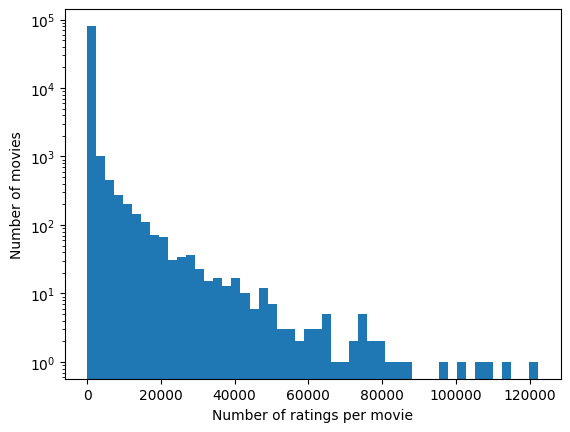

In [96]:
plt.hist(counts["n_ratings"], bins=50)
plt.xlabel("Number of ratings per movie")
plt.ylabel("Number of movies")
plt.yscale("log")  # log scale ajuda a ver a cauda longa
plt.show()


Conclusion:

- Most movies have less than 26 ratings (q3), with a median of 5 ratings.
- Its a very skewed distribution: since only 25% of the movies have more than 26 ratings but the mean number of nr of ratings is 406.

Close connection

In [97]:
con.close()
print("Connection closed")

Connection closed
